# Testing the VRA on key explosive transients

The VRA is trained on tested on only a few months of data, and as most ML algorithms it will perform best on behaviour it has seen before but may behave unpredictibally on rarer types of objects.
We cannot plan for every type of event but we can see how the VRA ranks some key explosions that we wouldn't want to miss.

In this notebook we will look at:
* AT2018cow https://star.pst.qub.ac.uk/sne/atlas4/candidate/1161600211221604900/
* AT2018kzr https://star.pst.qub.ac.uk/sne/atlas4/candidate/1082853451010638400/ - difficult, as only one detection on the second night
* SN2023zaw https://star.pst.qub.ac.uk/sne/atlas4/candidate/1042920151702536500/
* SN2023ufx https://star.pst.qub.ac.uk/sne/atlas4/candidate/1082451571211743600/ fast rise which is CV like, but is a SN
* AT2024eju https://star.pst.qub.ac.uk/sne/atlas4/candidate/1092635390093203000/ FXT, one night only, Ken thought CV, difficult to tell
* SN2024atk https://star.pst.qub.ac.uk/sne/atlas4/candidate/1131831130143639100/ make sure to catch early
* SN2020kyg https://star.pst.qub.ac.uk/sne/atlas4/candidate/1131139601225456000/ - fast and faint Iax, catch early
* SN2020aedm https://star.pst.qub.ac.uk/sne/atlas4/candidate/1111927571030630500/ luminous fast cooler
* SN2022ilv https://star.pst.qub.ac.uk/sne/atlas4/candidate/1151044210113554700/ orphan, catch early. Super-Channdra Ia

We want to ensure that, with our eyeballing policies, they looked at  **as soon aspossible**. We also don't want them to be caught up in the garbaging policies. 

### Key transient names and ATLAS IDs

In [1]:
objects_names = ['AT2018cow', 
                 'AT2018kzr',
                 'SN2023zaw',
                 'SN2023ufx',
                 'AT2024eju',
                 'SN2024atk',
                 'SN2020kyg',
                 'SN2020aedm',
                 'SN2022ilv',
                ]
atlas_ids = [1161600211221604900, 
             1082853451010638400,
             1042920151702536500,
             1082451571211743600,
             1092635390093203000,
             1131831130143639100,
             1131139601225456000,
             1111927571030630500,
             1151044210113554700,
            ]

In [2]:
%load_ext autoreload
%autoreload 2

from atlasvras.utils.prettify import vra_colors, label_to_color
from atlasvras.st3ph3n.dataprocessing import (LightCurvePipes, 
                                              add_dayN_col, 
                                              make_contextual_features, 
                                              make_day1_lcfeatures,
                                              make_update_lcfeatures,
                                              day1_lc_feature_columns,
                                              update_lc_feature_columns,
                                              context_feature_columns
                                             )
from atlasvras.utils.jsondata import JsonDataFromServer
import matplotlib.pyplot as plt
import pandas as pd 
from glob import glob
from joblib import load
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import gridspec
pd.options.mode.chained_assignment = None 



############## PLOT STYLE ################
# Comment out if you don't have the file
plt.style.use('vra')
##########################################


real_scorer_DAY1 = load('./train_scoring_models/hyperparameter_tuning/hp_tuning_day1/models/real_scorer_LR0.1_L210.0_randomsplit.joblib')
gal_scorer_DAY1 = load('./train_scoring_models/hyperparameter_tuning/hp_tuning_day1/models/gal_scorer_LR0.2_L210.0_randomsplit.joblib')


real_scorer_UPDATE = load('./train_scoring_models/hyperparameter_tuning/hp_tuning_update/models/real_scorer_LR0.1_L21.0_randomsplit.joblib')
gal_scorer_UPDATE =load('./train_scoring_models/hyperparameter_tuning/hp_tuning_update/models/gal_scorer_LR0.1_L210.0_randomsplit.joblib')


Configuration file not found:

    /home/stevance/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


### Also loading test data for the plot we'll make below

In [3]:
# "Day1" data
X_test_unbalanced_DAY1 = pd.read_csv('./data/features_and_labels_csv/day1/X_test_unbalanced_randomsplit.csv', index_col=0)
y_test_unbalanced_DAY1 = pd.read_csv('./data/features_and_labels_csv/day1/y_test_unbalanced_randomsplit.csv', index_col=0)
#  "Update" data 
X_test_unbalanced_UPDATE = pd.read_csv('./data/features_and_labels_csv/update/X_test_unbalanced.csv', index_col=0)

In [4]:
X_test_unbalanced_DAY1.head()

,Nnondet_std,Nnondet_mean,magdet_std,DET_Nsince_min5d,NON_Nsince_min5d,log10_std_ra_min5d,log10_std_dec_min5d,ra,dec,rb_pix,z,photoz,ebv_sfd,log10_sep_arcsec,SN,NT,ORPHAN,CV,UNCLEAR
ATLAS_ID,,,,,,,,,,,,,,,,,,,
1182934220174131200,5.507571,4.000000,0.490398,5,15,-3.511986,-4.041247,277.39261,-17.69247,0.587406,NaN,NaN,0.896667,0.184316,True,False,False,False,False
1204026810160742400,6.000000,3.000000,0.652700,4,20,-3.412679,-3.604623,310.11173,-16.12847,0.830008,NaN,NaN,0.047639,NaN,False,False,True,False,False
1075053310332829700,3.811593,3.744186,5.137411,3,5,-4.380559,-4.089134,117.72184,-33.47543,0.875261,NaN,NaN,2.085859,NaN,False,False,True,False,False
1071806431075237900,4.714952,3.692308,0.396306,7,12,-3.628152,-3.675681,109.52665,7.87669,0.433401,NaN,NaN,0.078401,NaN,False,False,True,False,False
1152642280473100300,0.707107,0.500000,1.732898,3,9,-4.051186,-3.981287,231.67619,-47.51677,0.346761,NaN,NaN,0.491876,NaN,False,False,True,False,False


# 1. Detailed example: 2018cow

In this section we tlak through how we create the features for our objects and some extra considerations we need to take when working with older ATLAS data. 


In [5]:
INDEX = 0

In [6]:
objects_names[INDEX], atlas_ids[INDEX]

('AT2018cow', 1161600211221604900)

## 1.1 Getting the lightcurve 

We're going to be use the `LightCurvePipes` object form the `atlasvras.st3ph3n.dataprocessing` module - it's the bits of the pipeline that handle ATLAS data to compile lightcurves and make the history dataframe just like we processed our samples when makign our training features. 

### Get the Json data from the server

In [7]:
atlas_json = JsonDataFromServer(str(atlas_ids[INDEX]))

#### **Note:**
If you want to add a mjd threshold to the data so you don't download all the nondetections at that sky location since the beginning of ATLAS you can do:

```
from datetime import datetime, timedelta
from astropy.time import Time


# Get the current date
now = datetime.now()
# Subtract N days from the current date.
date_N_days_ago = now - timedelta(days=4000) # go back enough days that you get the lightcurve and 100 days of history - here i picked 4000 days
# turn our date into MJD so we can put it in the API request
mjd_threshold = Time(pd.to_datetime(date_N_days_ago.strftime("%Y-%m-%d %H:%M:%S"))).mjd

atlas_json = JsonDataFromServer(str(atlas_ids[INDEX]), mjd_threshold=mjd_threshold)

```

I don't find this is that much faster when working with one object at a time so I didn't bother

### Make our LightCurve object

Grabs our detections and non detections from the messy Json, croppes it to upper and lower phases (in days) - default is (-100,16), puts it all in a lightcurve dataframe, and has the method to make the history dataframe. 

You can check the dosctring with:
```
LightCurvePipes?
```

In [8]:
lcp_day1 = LightCurvePipes(atlas_json)

In [9]:
lcp_day1.lightcurve.head()

,mjd,mag,magerr,ra,dec,band,det,phase_init
52,58205.590884,19.14,NaN,NaN,NaN,o,False,-79.409116
53,58205.602695,19.21,NaN,NaN,NaN,o,False,-79.397305
54,58205.614956,19.32,NaN,NaN,NaN,o,False,-79.385044
55,58205.626569,19.28,NaN,NaN,NaN,o,False,-79.373431
56,58207.523576,18.95,NaN,NaN,NaN,o,False,-77.476424


In [10]:
lcp_day1.non_detections.head()

,mjd,mag,magerr,ra,dec,band,det,phase_init
52,58205.590884,19.14,NaN,NaN,NaN,o,False,-79.409116
53,58205.602695,19.21,NaN,NaN,NaN,o,False,-79.397305
54,58205.614956,19.32,NaN,NaN,NaN,o,False,-79.385044
55,58205.626569,19.28,NaN,NaN,NaN,o,False,-79.373431
56,58207.523576,18.95,NaN,NaN,NaN,o,False,-77.476424


In [11]:
lcp_day1.detections.head()

,mjd,mag,magerr,ra,dec,band,det,phase_init
0,58285.441413,14.739,0.009,244.00091,22.26803,o,True,0.441413
1,58285.441413,14.888,0.007,244.00094,22.26805,o,True,0.441413
2,58285.449893,14.650,0.005,244.00090,22.26804,o,True,0.449893
3,58285.449893,14.713,0.008,244.00089,22.26804,o,True,0.449893
4,58285.453008,14.908,0.008,244.00099,22.26801,o,True,0.453008


In [12]:
lcp_day1.history

,mjd,mag,magerr,ra,dec,band,det,phase_init,first_mjd,last_mjd,N_dets


### Weird Caveat on `phase_init` for older datasets
`phase_init` which is the phase in days w.r.t entry in the eyeball list should be negative for the observations that caused the alert to be triggered (because they happened before the ingest code ran). In this case you can see the first detections for the cow are positive...

**[CHECK WITH KEN]** That's because until recently the dates on the exposures were the dates at... **wait wasn't it the start of the night? then it would make the mjd lower than the actual observation and wouldn't cause the problem... CHECK WHAT'S UP - [@Stephen] if you know what the reaosn is lmk** 


This causes issues with creating the `dayN` column and of course with creating the history as it clips everything >0 `phase_init` (and in the case of the cow there were not detections in the previous 100 days at that location).

So we add a cheeky **-1 to the `phase_init`** then run `.make_history()` again manually.

In [13]:
lcp_day1.lightcurve.phase_init -=1
lcp_day1.detections.phase_init -=1
lcp_day1.non_detections.phase_init -=1
lcp_day1.make_history()
lcp_day1.add_dayN_column()

In [14]:
lcp_day1.history

,mjd,mag,magerr,ra,dec,band,det,phase_init,first_mjd,last_mjd,N_dets,dayN
2,58285.449893,14.650,0.005,244.00090,22.26804,o,True,-0.550107,58285.441413,58285.481742,1,0
3,58285.449893,14.713,0.008,244.00089,22.26804,o,True,-0.550107,58285.441413,58285.481742,2,0
4,58285.453008,14.908,0.008,244.00099,22.26801,o,True,-0.546992,58285.441413,58285.481742,3,0
5,58285.453008,14.761,0.010,244.00095,22.26799,o,True,-0.546992,58285.441413,58285.481742,4,0
6,58285.461262,14.673,0.008,244.00090,22.26800,o,True,-0.538738,58285.441413,58285.481742,5,0
7,58285.461262,14.624,0.005,244.00090,22.26800,o,True,-0.538738,58285.441413,58285.481742,6,0
9,58285.464883,14.891,0.008,244.00097,22.26805,o,True,-0.535117,58285.441413,58285.481742,7,0
8,58285.464883,14.758,0.009,244.00092,22.26801,o,True,-0.535117,58285.441413,58285.481742,8,0
10,58285.473012,14.644,0.010,244.00092,22.26798,o,True,-0.526988,58285.441413,58285.481742,9,0
11,58285.473012,14.679,0.009,244.00092,22.26798,o,True,-0.526988,58285.441413,58285.481742,10,0


## 1.2 Make the features

We're going to focus on **Day 1 models** since we really want to catch these objects one the day they hit the eyeball list. 

We need to make **light curve features for our Day 1 models and contextual features**, so we get these columns:

In [15]:
X_test_unbalanced_DAY1.head(1)

,Nnondet_std,Nnondet_mean,magdet_std,DET_Nsince_min5d,NON_Nsince_min5d,log10_std_ra_min5d,log10_std_dec_min5d,ra,dec,rb_pix,z,photoz,ebv_sfd,log10_sep_arcsec,SN,NT,ORPHAN,CV,UNCLEAR
ATLAS_ID,,,,,,,,,,,,,,,,,,,
1182934220174131200,5.507571,4.0,0.490398,5,15,-3.511986,-4.041247,277.39261,-17.69247,0.587406,NaN,NaN,0.896667,0.184316,True,False,False,False,False


### Functions to make the features in `atlasvras.st3ph3n.dataprocessing`

In [16]:
# parse our LightCurvePipes object (corrcted for the messed up phase_init)
day1_lc_features = make_day1_lcfeatures(lcp_day1)

In [17]:
# parse the object that contains the Json data
# NOT THE JSON ITSELF (the object has utility methods this function needs)
contextual_features = make_contextual_features(atlas_json)

In [18]:
day1_features = day1_lc_features + contextual_features
day1_features

[0.0,
 0.0,
 0.10524203397067963,
 15,
 0,
 -4.532750774412599,
 -4.6222440575572055,
 244.00092,
 22.26801,
 0.999258,
 0.014145,
 0.020844,
 0.08679219,
 0.7368980448376441,
 True,
 False,
 False,
 False,
 False]

In [19]:
day1_lc_feature_columns+context_feature_columns

['Nnondet_std',
 'Nnondet_mean',
 'magdet_std',
 'DET_Nsince_min5d',
 'NON_Nsince_min5d',
 'log10_std_ra_min5d',
 'log10_std_dec_min5d',
 'ra',
 'dec',
 'rb_pix',
 'z',
 'photoz',
 'ebv_sfd',
 'log10_sep_arcsec',
 'SN',
 'NT',
 'ORPHAN',
 'CV',
 'UNCLEAR']

# 2. Now make Day 1 the features for all our examples and get ranks


## 2.1 Make features in a loop

Note all of them have the `phase_init` offset issue so the **-1** offset is being applied in the loop. 
You could add a check that `lcp_day1.history.shape[0]==0` before applying the correction if you want to try that with another example and are worried you'll offset something unnecessarily.

In [20]:
feature_list = []

for atlas_id in atlas_ids:
    atlas_json = JsonDataFromServer(str(atlas_id))
    lcp_day1 = LightCurvePipes(atlas_json)

    lcp_day1.lightcurve.phase_init -=1
    lcp_day1.detections.phase_init -=1
    lcp_day1.non_detections.phase_init -=1
    lcp_day1.make_history()
        
    lcp_day1.add_dayN_column()

    day1_lc_features = make_day1_lcfeatures(lcp_day1)
    contextual_features = make_contextual_features(atlas_json)
    features = day1_lc_features + contextual_features
    
    feature_list.append(features)

In [21]:
df_day1 = pd.DataFrame(feature_list)

In [22]:
df_day1.columns = day1_lc_feature_columns+context_feature_columns

In [23]:
df_day1

,Nnondet_std,Nnondet_mean,magdet_std,DET_Nsince_min5d,NON_Nsince_min5d,log10_std_ra_min5d,log10_std_dec_min5d,ra,dec,rb_pix,z,photoz,ebv_sfd,log10_sep_arcsec,SN,NT,ORPHAN,CV,UNCLEAR
0,0.00000,0.000000,0.105242,15,0,-4.532751,-4.622244,244.00092,22.26801,0.999258,0.014145,0.020844,0.086792,0.736898,True,False,False,False,False
1,0.00000,0.000000,0.117073,4,0,-4.240743,-4.139232,127.22272,1.11076,0.995519,NaN,0.134982,0.041235,-0.216089,True,False,False,False,False
2,0.00000,0.000000,0.260191,5,0,-3.444083,-3.904135,67.33429,70.42704,0.979358,0.010170,NaN,0.246369,1.325187,True,False,False,False,False
3,0.00000,0.000000,0.140545,8,0,-4.822192,-4.017475,126.21491,21.29540,0.999998,NaN,NaN,0.048767,0.383611,True,False,False,False,False
4,0.00000,0.000000,0.303647,3,0,-3.975391,-3.736615,141.64777,-9.53398,0.994695,NaN,NaN,0.048721,NaN,False,False,True,False,False
5,0.00000,0.000000,0.079271,7,0,-4.481192,-4.346915,199.62972,-14.61086,0.999913,0.009637,NaN,0.081209,1.105847,True,False,False,False,False
6,0.00000,0.000000,0.214826,8,0,-4.032075,-4.422549,197.91509,22.91552,0.999189,0.008736,NaN,0.013835,1.550528,True,False,False,False,False
7,0.00000,0.000000,0.110362,7,0,-4.408535,-4.669974,169.86507,3.10943,0.999964,0.143443,0.139852,0.048763,0.321649,True,False,False,False,False
8,0.57735,0.333333,0.150614,2,1,-3.788787,-4.305417,227.68456,-11.59932,0.993632,NaN,NaN,0.113175,0.537699,True,False,False,False,False


## 2.2 Put them in the models to get the scores and calculated the ranks

In [24]:
real_scores = real_scorer_DAY1.predict_proba(df_day1).T[1]
gal_scores = gal_scorer_DAY1.predict_proba(df_day1).T[1]

In [25]:
def rank_function(REAL_PRED, GAL_PRED, fudge_factor=0.4, max_score=10):
    ranks = np.sqrt((1-REAL_PRED)**2 + fudge_factor*(GAL_PRED)**2)
    max_distance = np.sqrt(fudge_factor**2 + 1)
    return (max_distance - ranks) * max_score / max_distance

In [26]:
rank_function(real_scores, gal_scores)

array([9.8085981 , 9.39438025, 7.13445284, 9.15244015, 6.34790676,
       9.74633813, 9.6118794 , 9.89889911, 8.43623266])

## 2.3 Make a neat plot

In [27]:
real_pred_TEST = real_scorer_DAY1.predict_proba(X_test_unbalanced_DAY1).T[1]
gal_pred_TEST = gal_scorer_DAY1.predict_proba(X_test_unbalanced_DAY1).T[1]

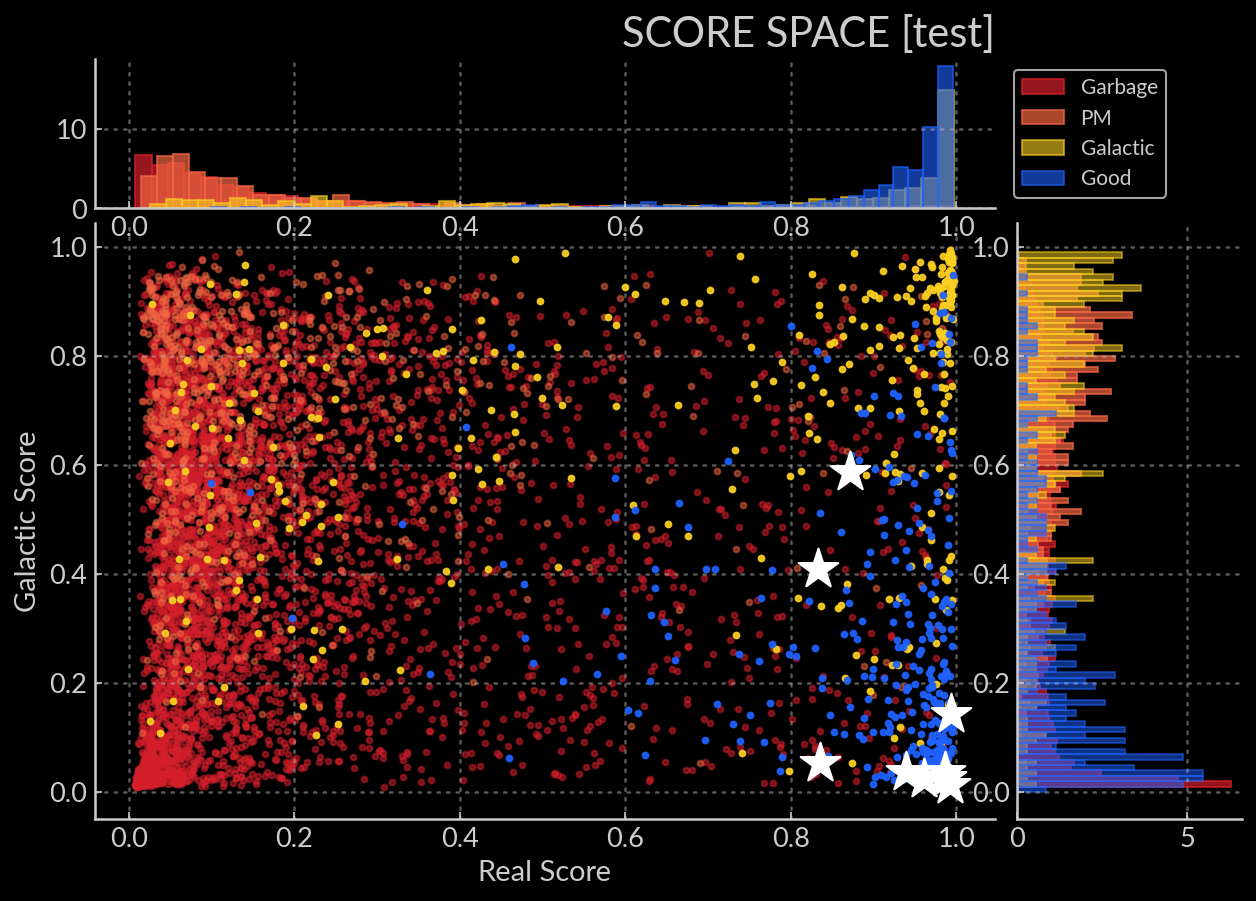

In [29]:
REAL_PRED = real_pred_TEST
GAL_PRED = gal_pred_TEST
Y = y_test_unbalanced_DAY1


TITLE = "SCORE SPACE [test]"
mask_garbage = Y.type == 'garbage'
mask_pm = Y.type == 'pm'
mask_good = Y.type == 'good'
mask_galactic = Y.type == 'galactic'

###################

fig = plt.figure(facecolor='black', figsize=(12, 8))
gs = gridspec.GridSpec(3, 3, 
                       width_ratios=[1, 4, 1], 
                       height_ratios=[1, 4, 1], 
                       wspace=0.05, hspace=0.05)


# Main 2D plot
ax_main = plt.subplot(gs[1, 1])
ax_main.scatter(REAL_PRED[mask_garbage], GAL_PRED[mask_garbage], 
           color=vra_colors['red'], 
            alpha=0.5,
            s=30, zorder=0.1)
ax_main.scatter(REAL_PRED[mask_pm], GAL_PRED[mask_pm], 
           color=vra_colors['orange'], 
            alpha=0.5,
            s=30, zorder=0.5)

ax_main.scatter(REAL_PRED[mask_galactic], GAL_PRED[mask_galactic], 
           color=vra_colors['yellow'], 
            alpha=0.9,
            s=30, zorder=10)

ax_main.scatter(REAL_PRED[mask_good], GAL_PRED[mask_good], 
           color=vra_colors['blue'], 
            alpha=0.9,
            s=30, zorder=1000)

ax_main.set_ylabel('Galactic Score')
ax_main.set_xlabel('Real Score')

# Top 1D marginalized distribution
ax_top = plt.subplot(gs[0, 1], sharex=ax_main)
__ = ax_top.hist(REAL_PRED[mask_garbage], bins=50, 
                 color=vra_colors['red'], 
                 edgecolor=vra_colors['red'],
                 alpha=0.7, 
             density=True,
                 label='Garbage'
           )

__ = ax_top.hist(REAL_PRED[mask_pm], bins=50, 
                 color=vra_colors['orange'], 
                 edgecolor=vra_colors['orange'],
                 alpha=0.7,
             density=True,
                 label='PM'
           )

__ = ax_top.hist(REAL_PRED[mask_galactic], bins=50, 
                 color=vra_colors['yellow'], 
                 edgecolor=vra_colors['yellow'],
                 alpha=0.6,
             density=True,
                 label='Galactic'
           )

__ = ax_top.hist(REAL_PRED[mask_good], bins=50, 
                 color=vra_colors['blue'], 
                 edgecolor=vra_colors['blue'],
                 alpha=0.6,
             density=True,
                 label='Good'
           )

# Right 1D marginalized distribution
ax_right = plt.subplot(gs[1, 2], sharey=ax_main)



__ = ax_right.hist(GAL_PRED[mask_garbage], bins=np.arange(0,1,0.01), orientation='horizontal',
                 color=vra_colors['red'], 
                 edgecolor=vra_colors['red'],
                 alpha=0.7, 
             density=True
           )

__ = ax_right.hist(GAL_PRED[mask_pm], bins=np.arange(0,1,0.01),  orientation='horizontal',
                 color=vra_colors['orange'], 
                 edgecolor=vra_colors['orange'],
                 alpha=0.7,
             density=True
           )

__ = ax_right.hist(GAL_PRED[mask_galactic], bins=np.arange(0,1,0.01),  orientation='horizontal',
                 color=vra_colors['yellow'], 
                 edgecolor=vra_colors['yellow'],
                 alpha=0.5,
             density=True
           )

__ = ax_right.hist(GAL_PRED[mask_good], bins=np.arange(0,1,0.01),  orientation='horizontal',
                 color=vra_colors['blue'], 
                 edgecolor=vra_colors['blue'],
                 alpha=0.5,
             density=True
           )

#### TITLE
ax_top.set_title(TITLE, loc='right', fontsize=20)

ax_top.legend(bbox_to_anchor=[1.01, 1.0, 0.0, 0.0])
    
    
ax_main.scatter(real_scores, gal_scores, marker ='*', color='w', zorder=1000, s=400)

Text(0.5, 0.2, 'Eyeball\nRegion')

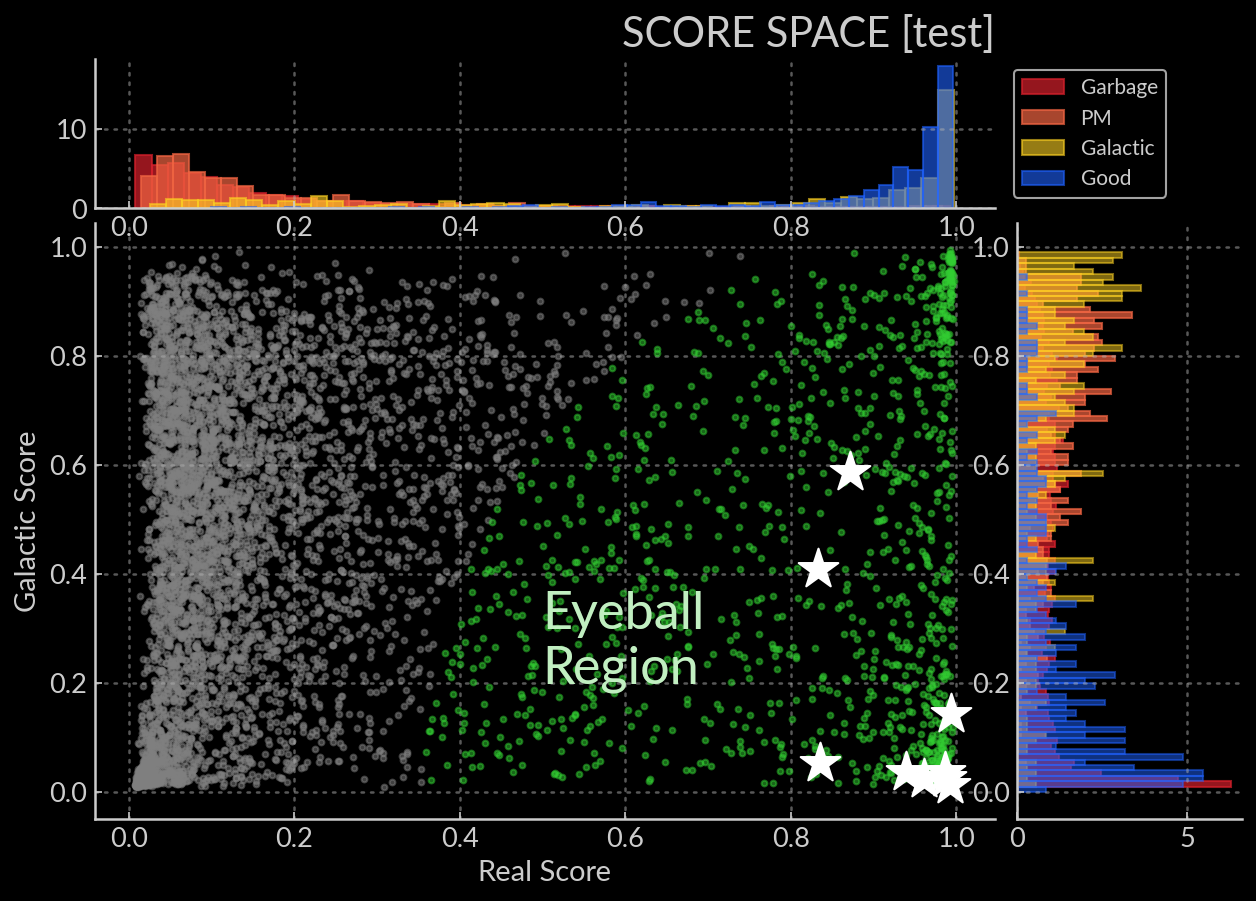

In [58]:
REAL_PRED = real_pred_TEST
GAL_PRED = gal_pred_TEST
Y = y_test_unbalanced_DAY1

ranks_test = rank_function(REAL_PRED, GAL_PRED)

TITLE = "SCORE SPACE [test]"
mask_garbage = Y.type == 'garbage'
mask_pm = Y.type == 'pm'
mask_good = Y.type == 'good'
mask_galactic = Y.type == 'galactic'

mask_eyeball = ranks_test > 4
###################

fig = plt.figure(facecolor='black', figsize=(12, 8))
gs = gridspec.GridSpec(3, 3, 
                       width_ratios=[1, 4, 1], 
                       height_ratios=[1, 4, 1], 
                       wspace=0.05, hspace=0.05)


# Main 2D plot
ax_main = plt.subplot(gs[1, 1])
ax_main.scatter(REAL_PRED[mask_eyeball], GAL_PRED[mask_eyeball], 
           color='limegreen', label='eyeball region',
            alpha=0.5,
            s=30, zorder=100)
ax_main.scatter(REAL_PRED[~mask_eyeball], GAL_PRED[~mask_eyeball], 
           color='grey', 
            alpha=0.5,
            s=30, zorder=0.5)


ax_main.set_ylabel('Galactic Score')
ax_main.set_xlabel('Real Score')

# Top 1D marginalized distribution
ax_top = plt.subplot(gs[0, 1], sharex=ax_main)
__ = ax_top.hist(REAL_PRED[mask_garbage], bins=50, 
                 color=vra_colors['red'], 
                 edgecolor=vra_colors['red'],
                 alpha=0.7, 
             density=True,
                 label='Garbage'
           )

__ = ax_top.hist(REAL_PRED[mask_pm], bins=50, 
                 color=vra_colors['orange'], 
                 edgecolor=vra_colors['orange'],
                 alpha=0.7,
             density=True,
                 label='PM'
           )

__ = ax_top.hist(REAL_PRED[mask_galactic], bins=50, 
                 color=vra_colors['yellow'], 
                 edgecolor=vra_colors['yellow'],
                 alpha=0.6,
             density=True,
                 label='Galactic'
           )

__ = ax_top.hist(REAL_PRED[mask_good], bins=50, 
                 color=vra_colors['blue'], 
                 edgecolor=vra_colors['blue'],
                 alpha=0.6,
             density=True,
                 label='Good'
           )

# Right 1D marginalized distribution
ax_right = plt.subplot(gs[1, 2], sharey=ax_main)



__ = ax_right.hist(GAL_PRED[mask_garbage], bins=np.arange(0,1,0.01), orientation='horizontal',
                 color=vra_colors['red'], 
                 edgecolor=vra_colors['red'],
                 alpha=0.7, 
             density=True
           )

__ = ax_right.hist(GAL_PRED[mask_pm], bins=np.arange(0,1,0.01),  orientation='horizontal',
                 color=vra_colors['orange'], 
                 edgecolor=vra_colors['orange'],
                 alpha=0.7,
             density=True
           )

__ = ax_right.hist(GAL_PRED[mask_galactic], bins=np.arange(0,1,0.01),  orientation='horizontal',
                 color=vra_colors['yellow'], 
                 edgecolor=vra_colors['yellow'],
                 alpha=0.5,
             density=True
           )

__ = ax_right.hist(GAL_PRED[mask_good], bins=np.arange(0,1,0.01),  orientation='horizontal',
                 color=vra_colors['blue'], 
                 edgecolor=vra_colors['blue'],
                 alpha=0.5,
             density=True
           )

#### TITLE
ax_top.set_title(TITLE, loc='right', fontsize=20)

ax_top.legend(bbox_to_anchor=[1.01, 1.0, 0.0, 0.0])
    
    
ax_main.scatter(real_scores, gal_scores, marker ='*', color='w', zorder=1000, s=400)

ax_main.text(0.5, 0.2, 'Eyeball\nRegion', color='w', fontsize=25, zorder=15000)
ax_main.text(0.5, 0.2, 'Eyeball\nRegion', color='limegreen', fontsize=25, zorder=15001, alpha=0.3)

In [59]:
df_day1_scores = pd.DataFrame([real_scores, gal_scores]).T

In [60]:
df_day1_scores.index=objects_names

In [61]:
df_day1_scores.columns=['preal', 'pgal']

In [52]:
df_day1_scores['ranks']=rank_function(real_scores, gal_scores)

In [53]:
df_day1_scores

,preal,pgal,ranks
AT2018cow,0.988228,0.026757,9.800690
AT2018kzr,0.939287,0.037699,9.406926
SN2023zaw,0.832844,0.410215,7.005613
SN2023ufx,0.993237,0.143938,9.087651
AT2024eju,0.871221,0.587653,6.108965
SN2024atk,0.986034,0.037126,9.734033
SN2020kyg,0.961313,0.025036,9.619466
SN2020aedm,0.992953,0.013125,9.895771
SN2022ilv,0.834945,0.052988,8.486143


### All of them have rank >6 on day 1, even AT2024eju which was very faint.

**Note that NONE OF THESE are in the training or test set, so this is a genuine test of the VRA's performance on data that has not been seen before**

(We use the test set to pick the hyperparameters so it's really a validation set not a test set)